### Demo-02: n-PINN for 2D N-S Equations: Lid Driven Cavity (Re400)

   
    1. PINN for 2D N-S equations (lid driven cavity):
        1.0. Data
        1.1. Geometry & BC
        1.2. Sampling plan
        1.3. a-PINN / n-PINN / can-PINN
    2. Optimize PINN: [SGD]
    3. Visualize results



Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pylab as plt 
from matplotlib import cm

import os
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, Callback
import tensorflow.keras.backend as K

from IPython.display import clear_output
from time import time, gmtime, strftime, localtime

import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy import pi, exp

import seaborn as sns

## run on CPUs...
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# disable eager excution
tf.compat.v1.disable_eager_execution()

### 1. PINN for 2D N-S equations (lid driven cavity)

    1. Incompressible Navier–Stokes equation for 2D fluid case: u(x, y), v(x, y), p(x, y)    , x∈[0, 1], y∈[-1, 0]
        - Continuity equation : u_x + v_y = 0
        - Momentum equation 1 : u*u_x + v*u_y = -p_x + vis*(u_xx + u_yy)
        - Momentum equation 2 : u*v_x + v*v_y = -p_y + vis*(v_xx + v_yy)
        
    2. BC:
        - Top    : u = 1 , v = 0 , p_n = 0
        - Left   : u = 0 , v = 0 , p_n = 0
        - Right  : u = 0 , v = 0 , p_n = 0
        - Bottom : u = 0 , v = 0 , p_n = 0
         
    3. Constants, coefficients:
        - density = 1, therefore not appear in momentum equations
        - vis: kinematic viscosity (1 / Re)

#### 1.0. Data

In [3]:
# PDE
Re = 400

# grid size
n = 51

In [4]:
# collect all .csv files from data folder
datadir = os.path.join(os.getcwd(), "d00_data")

sim = pd.read_csv(os.path.join(datadir, 'RE%d_LDC_GROUND_TRUTH_%dX%d.csv'%(Re, n, n)))
sim['x'], sim['y'] = sim['x'], sim['y'] - 1

#### 1.1. Geometry & BC

In [5]:
# spatial-temporal domain
#T = 1.0   #2

# computational boundary
x_l, x_u, y_l, y_u = 0, 1, -1, 0
ext = [x_l, x_u, y_l, y_u]

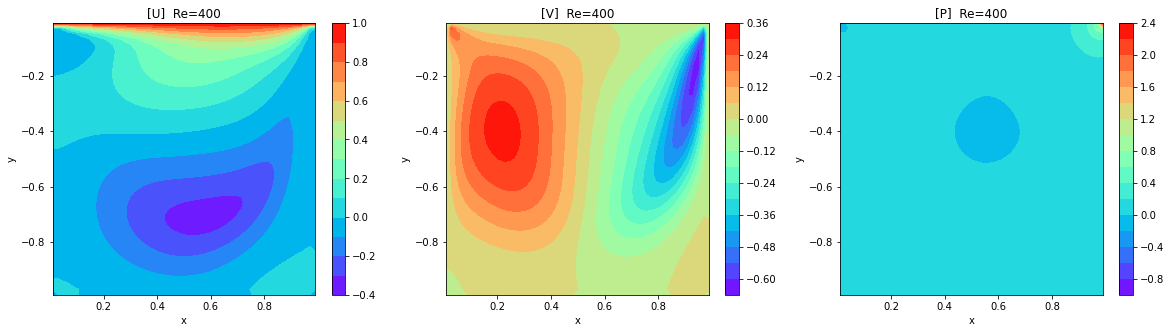

In [6]:
# visualize simulation data   
fig = plt.figure(figsize=(20, 5))
con_lv = 15
# u
ax1 = fig.add_subplot(1,3,1)
_u = sim.u.values.reshape(n, n)
plt.contourf(_u, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title('[U]  Re=%d' %Re);

# v
ax1 = fig.add_subplot(1,3,2)
_v = sim.v.values.reshape(n, n)
plt.contourf(_v, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title('[V]  Re=%d' %Re);
# p
ax1 = fig.add_subplot(1,3,3)
_p = sim.p.values.reshape(n, n)
plt.contourf(_p, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title('[P]  Re=%d' %Re);

#### 1.2. Sampling plan

# training sample = 2601  (dx = 2.00e-02, dy = 2.00e-02)
(2601, 4) (2601, 3)


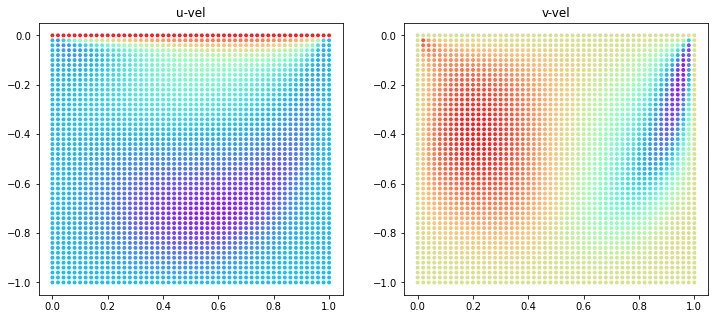

In [7]:
# dx & dy
vdx = (x_u - x_l) / (n - 1) #/ 2
vdy = (y_u - y_l) / (n - 1) #/ 2

# training sample (x * y) -> (u, v, p)
X_train = np.vstack([sim.x.values, sim.y.values, vdx * np.ones_like(sim.x.values), vdy * np.ones_like(sim.x.values)]).T
y_train = sim[['u', 'v', 'p']].values

print ('# training sample = %3d  (dx = %.2e, dy = %.2e)' %(len(y_train), vdx, vdy))
print (X_train.shape, y_train.shape)

# view
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1,2,1); _sc = 1.
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train[:, 0], marker='H', s=10, alpha=.85, cmap='rainbow'); plt.title('u-vel');
ax1 = fig.add_subplot(1,2,2); _sc = .5
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train[:, 1], marker='H', s=10, alpha=.85, cmap='rainbow'); plt.title('v-vel');

# BC sample = 200


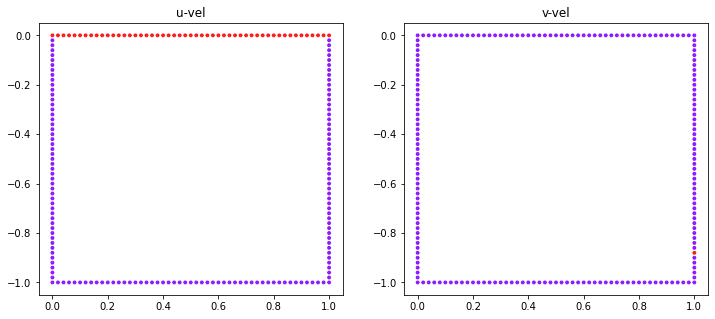

In [8]:
# BC sample
bc = np.where((X_train[:, 0] == x_u) | (X_train[:, 0] == x_l) | (X_train[:, 1] == y_u) | (X_train[:, 1] == y_l))[0]
X_bc, y_bc = X_train[bc], y_train[bc]

print ('# BC sample = %d' %len(y_bc))

# view
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1,2,1); _sc = 1.
plt.scatter(X_bc[:, 0], X_bc[:, 1], c=y_bc[:, 0], marker='H', s=10, alpha=.85, cmap='rainbow'); plt.title('u-vel');
ax1 = fig.add_subplot(1,2,2); _sc = .5
plt.scatter(X_bc[:, 0], X_bc[:, 1], c=y_bc[:, 1], marker='H', s=10, alpha=.85, cmap='rainbow'); plt.title('v-vel');

In [9]:
# evaluation sample
X_eval, y_eval = X_train, y_train

# PDE sample
X_pde, y_pde = X_train, y_train

# IC sample
X_ic, y_ic = X_bc, y_bc

In [10]:
# define sampling plan
class SamplingPlan_Fix(keras.utils.Sequence):
    
    def __init__(self, data=( ), batch_size=( ), batch_per_epoch=1):
        # sampling plan: data=(X_pde, y_pde, X_ic, y_ic, X_bc, y_bc), batch_size=(n_pde, n_ic, n_bc)
        self.X, self.y, self.X_ic, self.y_ic, self.X_bc, self.y_bc = data
        self.n, self.n_ic, self.n_bc = len(self.X), len(self.X_ic), len(self.X_bc)
        self.ID, self.ID_ic, self.ID_bc = np.arange(self.n), np.arange(self.n_ic), np.arange(self.n_bc)
        # input parameters
        self.batch_size, self.batch_ic, self.batch_bc = batch_size
        self.batch_per_epoch = batch_per_epoch
        
    def __len__(self):
        # number of mini batch per epoch
        return self.batch_per_epoch
    
    def __getitem__(self, idx):
        # shuffle & pick collocation sample
        np.random.shuffle(self.ID)
        idxs = self.ID[:self.batch_size]
        batch_X, batch_y = self.X[idxs], self.y[idxs]
        # shuffle & pick ic sample
        np.random.shuffle(self.ID_ic)
        idxs = self.ID_ic[:self.batch_ic]
        batch_X_ic, batch_y_ic = self.X_ic[idxs], self.y_ic[idxs]            
        # shuffle & pick bc sample 
        np.random.shuffle(self.ID_bc)
        idxs = self.ID_bc[:self.batch_bc]
        batch_X_bc, batch_y_bc = self.X_bc[idxs], self.y_bc[idxs]
        # combine all sample
        batch_X, batch_y = np.vstack([batch_X, batch_X_ic, batch_X_bc]), np.vstack([batch_y, batch_y_ic, batch_y_bc])        
        return (batch_X, batch_y)

#### 1.3. a-PINN / n-PINN / can-PINN

In [11]:
# specify a-PINN / n-PINN / can-PINN
def create_nn(scheme, ff, n_ffs, sigma, lmbda, n_nodes, acf, lr_int):
    # input layers -> split into (x, y, dx, dy)
    inputs = layers.Input(shape=(4,))
    x, y, dx, dy = layers.Lambda( lambda k: tf.split(k, num_or_size_splits=4, axis=1))(inputs)

    # features mapping
    initializer_ff = tf.keras.initializers.TruncatedNormal(stddev=sigma)  # features initializer
    
    if (ff == 'FF'):
        hidden_f0 = layers.Dense(n_ffs, activation='linear', use_bias=False, kernel_initializer=initializer_ff)(layers.Concatenate()([x, y]))
        hidden_sin, hidden_cos = tf.math.sin(2*tf.constant(pi)*hidden_f0), tf.math.cos(2*tf.constant(pi)*hidden_f0)
        hidden_ff = layers.Concatenate()([hidden_sin, hidden_cos])
        
    if (ff == 'SF') or (ff == 'SIREN'):
        hidden_f0 = layers.Dense(n_ffs*2, activation='linear', kernel_initializer=initializer_ff)(layers.Concatenate()([x, y]))
        hidden_ff = tf.math.sin(2*tf.constant(pi)*hidden_f0)

    if (ff == 'HF'):
        hidden_ff = layers.Dense(n_ffs*2, activation=acf, kernel_initializer=initializer_ff)(layers.Concatenate()([x, y]))

    # hidden layers
    if (ff == 'SIREN'):
        initializer = tf.keras.initializers.HeUniform()  # hidden layers initializer
        hidden_1 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_ff)
        hidden_2 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_1)
        hidden_l = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_2)
    else:
        initializer = tf.keras.initializers.GlorotUniform()  # hidden layers initializer
        hidden_1 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_ff)
        hidden_2 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_1)
        hidden_l = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_2)

    # split layers - u
    if (ff == 'SIREN'):
        hidden_u1 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_l)
        hidden_u2 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_u1)
        hidden_ul = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_u2)
    else:
        hidden_u1 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_l)
        hidden_u2 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_u1)
        hidden_ul = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_u2)

    # split layers - v
    if (ff == 'SIREN'):
        hidden_v1 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_l)
        hidden_v2 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_v1)
        hidden_vl = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_v2)
    else:
        hidden_v1 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_l)
        hidden_v2 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_v1)
        hidden_vl = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_v2)  
        
    # split layers - p
    if (ff == 'SIREN'):
        hidden_p1 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_l)
        hidden_p2 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_p1)
        hidden_pl = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_p2)
    else:
        hidden_p1 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_l)
        hidden_p2 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_p1)
        hidden_pl = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_p2)          
        
    # output layers
    u = layers.Dense(1, use_bias=False, name="U")(hidden_ul)
    v = layers.Dense(1, use_bias=False, name="V")(hidden_vl)
    p = layers.Dense(1, use_bias=False, name="P")(hidden_pl)  
    
    # initiate model
    outputs = layers.Concatenate()([u, v, p]) 
    nn = models.Model(inputs=inputs, outputs=outputs)
    
    # axillary PDE outputs
    u_x, u_y = K.gradients(u, x)[0], K.gradients(u, y)[0]
    v_x, v_y = K.gradients(v, x)[0], K.gradients(v, y)[0]
    p_x, p_y = K.gradients(p, x)[0], K.gradients(p, y)[0]
    u_xx, u_yy = K.gradients(u_x, x)[0], K.gradients(u_y, y)[0]
    v_xx, v_yy = K.gradients(v_x, x)[0], K.gradients(v_y, y)[0]    

    # initial & boundary conditions:
    # Top    : u = 1 , v = 0
    # Left   : u = 0 , v = 0
    # Right  : u = 0 , v = 0
    # Bottom : u = 0 , v = 0
    _top, _bottom = tf.equal(y, y_u), tf.equal(y, y_l)
    _left, _right = tf.equal(x, x_l), tf.equal(x, x_u)
    _bc = tf.logical_or( tf.logical_or(_top, _bottom) , tf.logical_or(_left, _right) )

    u_top, v_top = tf.boolean_mask(u, _top), tf.boolean_mask(v, _top)
    bc_top = tf.compat.v1.losses.mean_squared_error(labels=tf.ones_like(u_top), predictions=u_top) + \
             tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(v_top), predictions=v_top)

    u_left, v_left = tf.boolean_mask(u, _left & ~_top), tf.boolean_mask(v, _left & ~_top)
    bc_left = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(u_left), predictions=u_left) + \
              tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(v_left), predictions=v_left)

    u_right, v_right = tf.boolean_mask(u, _right & ~_top), tf.boolean_mask(v, _right & ~_top)
    bc_right = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(u_right), predictions=u_right) + \
               tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(v_right), predictions=v_right)

    u_bottom, v_bottom = tf.boolean_mask(u, _bottom), tf.boolean_mask(v, _bottom)
    bc_bottom = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(u_bottom), predictions=u_bottom) + \
                tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(v_bottom), predictions=v_bottom)
    
    bc_mse = bc_top + bc_left + bc_right + bc_bottom
    
    # PDE (NS equation)
    # Continuity equation : u_x + v_y = 0
    # Momentum equation 1 : u_t + u*u_x + v*u_y = -(1/rho)*p_x + nu*(u_xx + u_yy)
    # Momentum equation 2 : v_t + u*v_x + v*v_y = -(1/rho)*p_y + nu*(v_xx + v_yy)
    
    # auto-differentian PDE (a-pde)
    a_residuals_continuity = u_x + v_y
    a_residuals_momentum_1 = u*u_x + v*u_y + p_x - 1.0/Re*(u_xx + u_yy)
    a_residuals_momentum_2 = u*v_x + v*v_y + p_y - 1.0/Re*(v_xx + v_yy)
    
    # exclude BC points 
    a_residuals_continuity = tf.boolean_mask(a_residuals_continuity, ~_bc)
    a_residuals_momentum_1 = tf.boolean_mask(a_residuals_momentum_1, ~_bc)
    a_residuals_momentum_2 = tf.boolean_mask(a_residuals_momentum_2, ~_bc)
    
    a_mse_continuity = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(a_residuals_continuity),
                                                              predictions=a_residuals_continuity)
    a_mse_momentum_1 = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(a_residuals_momentum_1),
                                                              predictions=a_residuals_momentum_1)
    a_mse_momentum_2 = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(a_residuals_momentum_2),
                                                              predictions=a_residuals_momentum_2)
    a_pde_mse = a_mse_continuity + a_mse_momentum_1 + a_mse_momentum_2
    a_pde_mse = a_pde_mse / lmbda     
    
    
    # numerical differentiation PDE (n-pde)
    # dx & dy get from input
    xE, xW = x + dx, x - dx
    yN, yS = y + dy, y - dy
    uvpE  = nn(tf.stack([xE, y, dx, dy], 1))
    uvpW  = nn(tf.stack([xW, y, dx, dy], 1))
    uvpN  = nn(tf.stack([x, yN, dx, dy], 1))
    uvpS  = nn(tf.stack([x, yS, dx, dy], 1))
    uE, vE, pE  = tf.split(uvpE, num_or_size_splits=3, axis=1)
    uW, vW, pW  = tf.split(uvpW, num_or_size_splits=3, axis=1)
    uN, vN, pN  = tf.split(uvpN, num_or_size_splits=3, axis=1)
    uS, vS, pS  = tf.split(uvpS, num_or_size_splits=3, axis=1)
    
    # second order
    xEE, xWW = x + 2.0*dx, x - 2.0*dx
    yNN, ySS = y + 2.0*dy, y - 2.0*dy    
    uvpEE = nn(tf.stack([xEE, y, dx, dy], 1))
    uvpWW = nn(tf.stack([xWW, y, dx, dy], 1))
    uvpNN = nn(tf.stack([x, yNN, dx, dy], 1))
    uvpSS = nn(tf.stack([x, ySS, dx, dy], 1))  
    uEE, vEE, _ = tf.split(uvpEE, num_or_size_splits=3, axis=1)
    uWW, vWW, _ = tf.split(uvpWW, num_or_size_splits=3, axis=1)
    uNN, vNN, _ = tf.split(uvpNN, num_or_size_splits=3, axis=1)
    uSS, vSS, _ = tf.split(uvpSS, num_or_size_splits=3, axis=1)
    
    uc_e, uc_w = 0.5*(uE + u), 0.5*(uW + u) 
    vc_n, vc_s = 0.5*(vN + v), 0.5*(vS + v)
    div = (uc_e - uc_w) /dx + (vc_n - vc_s) /dy
    
    # 2nd upwind
    Uem_uw2 = 1.5*u  - 0.5*uW
    Uep_uw2 = 1.5*uE - 0.5*uEE  
    Uwm_uw2 = 1.5*uW - 0.5*uWW
    Uwp_uw2 = 1.5*u  - 0.5*uE
    Ue_uw2 = tf.where(tf.greater_equal(uc_e, 0.0), Uem_uw2, Uep_uw2)
    Uw_uw2 = tf.where(tf.greater_equal(uc_w, 0.0), Uwm_uw2, Uwp_uw2)
        
    Unm_uw2 = 1.5*u  - 0.5*uS
    Unp_uw2 = 1.5*uN - 0.5*uNN    
    Usm_uw2 = 1.5*uS - 0.5*uSS
    Usp_uw2 = 1.5*u  - 0.5*uN
    Un_uw2 = tf.where(tf.greater_equal(vc_n, 0.0), Unm_uw2, Unp_uw2)
    Us_uw2 = tf.where(tf.greater_equal(vc_s, 0.0), Usm_uw2, Usp_uw2)

    Vem_uw2 = 1.5*v  - 0.5*vW
    Vep_uw2 = 1.5*vE - 0.5*vEE
    Vwm_uw2 = 1.5*vW - 0.5*vWW
    Vwp_uw2 = 1.5*v  - 0.5*vE
    Ve_uw2 = tf.where(tf.greater_equal(uc_e, 0.0), Vem_uw2, Vep_uw2)
    Vw_uw2 = tf.where(tf.greater_equal(uc_w, 0.0), Vwm_uw2, Vwp_uw2)
        
    Vnm_uw2 = 1.5*v  - 0.5*vS
    Vnp_uw2 = 1.5*vN - 0.5*vNN    
    Vsm_uw2 = 1.5*vS - 0.5*vSS
    Vsp_uw2 = 1.5*v  - 0.5*vN
    Vn_uw2 = tf.where(tf.greater_equal(vc_n, 0.0), Vnm_uw2, Vnp_uw2)
    Vs_uw2 = tf.where(tf.greater_equal(vc_s, 0.0), Vsm_uw2, Vsp_uw2)
        
    UUx_uw2 = (uc_e*Ue_uw2 - uc_w*Uw_uw2) /dx
    VUy_uw2 = (vc_n*Un_uw2 - vc_s*Us_uw2) /dy
    UVx_uw2 = (uc_e*Ve_uw2 - uc_w*Vw_uw2) /dx
    VVy_uw2 = (vc_n*Vn_uw2 - vc_s*Vs_uw2) /dy
    
    # 2nd central difference    
    Uxx_cd2 = (uE - 2.0*u + uW)/ (dx*dx) 
    Uyy_cd2 = (uN - 2.0*u + uS)/ (dy*dy) 
    Vxx_cd2 = (vE - 2.0*v + vW)/ (dx*dx) 
    Vyy_cd2 = (vN - 2.0*v + vS)/ (dy*dy) 

    pe_cd2 = (p + pE) /2.0 
    pw_cd2 = (pW + p) /2.0 
    pn_cd2 = (p + pN) /2.0 
    ps_cd2 = (pS + p) /2.0 
    
    Px_cd2 = (pe_cd2 - pw_cd2) /dx
    Py_cd2 = (pn_cd2 - ps_cd2) /dy
        
    n_residuals_continuity = div
    n_residuals_momentum_1 = UUx_uw2 + VUy_uw2 - 1.0/Re *(Uxx_cd2 + Uyy_cd2) - u*div + Px_cd2
    n_residuals_momentum_2 = UVx_uw2 + VVy_uw2 - 1.0/Re *(Vxx_cd2 + Vyy_cd2) - v*div + Py_cd2   
    
    # exclude BC points 
    n_residuals_continuity = tf.boolean_mask(n_residuals_continuity, ~_bc)
    n_residuals_momentum_1 = tf.boolean_mask(n_residuals_momentum_1, ~_bc)
    n_residuals_momentum_2 = tf.boolean_mask(n_residuals_momentum_2, ~_bc)
    
    n_mse_continuity = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(n_residuals_continuity),
                                                              predictions=n_residuals_continuity)
    n_mse_momentum_1 = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(n_residuals_momentum_1),
                                                              predictions=n_residuals_momentum_1)
    n_mse_momentum_2 = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(n_residuals_momentum_2),
                                                              predictions=n_residuals_momentum_2)
    n_pde_mse = n_mse_continuity + n_mse_momentum_1 + n_mse_momentum_2
    n_pde_mse = n_pde_mse / lmbda     
    
    
    # coupled automatic-numerical differentiation PDE (can-pde)
    uE_x, uW_x = K.gradients(uE, xE)[0], K.gradients(uW, xW)[0]
    uN_y, uS_y = K.gradients(uN, yN)[0], K.gradients(uS, yS)[0]
    
    vE_x, vW_x = K.gradients(vE, xE)[0], K.gradients(vW, xW)[0]
    vN_y, vS_y = K.gradients(vN, yN)[0], K.gradients(vS, yS)[0]   
    
    pE_x, pW_x = K.gradients(pE, xE)[0], K.gradients(pW, xW)[0]
    pN_y, pS_y = K.gradients(pN, yN)[0], K.gradients(pS, yS)[0]        
    
    # can 2nd upwind
    Uem_cuw2 = u  +  u_x*dx /2.0 #+ (uE_x - u_x)*dx /8.0
    Uep_cuw2 = uE - uE_x*dx /2.0 #+ (uE_x - u_x)*dx /8.0  
    Uwm_cuw2 = uW + uW_x*dx /2.0 #+ (u_x - uW_x)*dx /8.0
    Uwp_cuw2 = u  -  u_x*dx /2.0 #+ (u_x - uW_x)*dx /8.0
    Ue_cuw2 = tf.where(tf.greater_equal(uc_e, 0.0), Uem_cuw2, Uep_cuw2)
    Uw_cuw2 = tf.where(tf.greater_equal(uc_w, 0.0), Uwm_cuw2, Uwp_cuw2)    
    
    Unm_cuw2 = u  +  u_y*dy /2.0 #+ (uN_y - u_y)*dy /8.0
    Unp_cuw2 = uN - uN_y*dy /2.0 #+ (uN_y - u_y)*dy /8.0 
    Usm_cuw2 = uS + uS_y*dy /2.0 #+ (u_y - uS_y)*dy /8.0
    Usp_cuw2 = u  -  u_y*dy /2.0 #+ (u_y - uS_y)*dy /8.0
    Un_cuw2 = tf.where(tf.greater_equal(vc_n, 0.0), Unm_cuw2, Unp_cuw2)
    Us_cuw2 = tf.where(tf.greater_equal(vc_s, 0.0), Usm_cuw2, Usp_cuw2)

    Vem_cuw2 = v  +  v_x*dx /2.0 #+ (vE_x - v_x)*dx /8.0
    Vep_cuw2 = vE - vE_x*dx /2.0 #+ (vE_x - v_x)*dx /8.0
    Vwm_cuw2 = vW + vW_x*dx /2.0 #+ (v_x - vW_x)*dx /8.0
    Vwp_cuw2 = v  -  v_x*dx /2.0 #+ (v_x - vW_x)*dx /8.0
    Ve_cuw2 = tf.where(tf.greater_equal(uc_e, 0.0), Vem_cuw2, Vep_cuw2)
    Vw_cuw2 = tf.where(tf.greater_equal(uc_w, 0.0), Vwm_cuw2, Vwp_cuw2)
        
    Vnm_cuw2 = v  +  v_y*dy /2.0 #+ (vN_y - v_y)*dy /8.0
    Vnp_cuw2 = vN - vN_y*dy /2.0 #+ (vN_y - v_y)*dy /8.0
    Vsm_cuw2 = vS + vS_y*dy /2.0 #+ (v_y - vS_y)*dy /8.0
    Vsp_cuw2 = v  -  v_y*dy /2.0 #+ (v_y - vS_y)*dy /8.0
    Vn_cuw2 = tf.where(tf.greater_equal(vc_n, 0.0), Vnm_cuw2, Vnp_cuw2)
    Vs_cuw2 = tf.where(tf.greater_equal(vc_s, 0.0), Vsm_cuw2, Vsp_cuw2)    
    
    UUx_cuw2 = (uc_e*Ue_cuw2 - uc_w*Uw_cuw2) /dx
    VUy_cuw2 = (vc_n*Un_cuw2 - vc_s*Us_cuw2) /dy
    UVx_cuw2 = (uc_e*Ve_cuw2 - uc_w*Vw_cuw2) /dx
    VVy_cuw2 = (vc_n*Vn_cuw2 - vc_s*Vs_cuw2) /dy       
    
    # can 2nd central difference    
    pe_ccd2 = (p + pE) /2.0 - (pE_x - p_x)*dx /8.0
    pw_ccd2 = (pW + p) /2.0 - (p_x - pW_x)*dx /8.0
    pn_ccd2 = (p + pN) /2.0 - (pN_y - p_y)*dy /8.0
    ps_ccd2 = (pS + p) /2.0 - (p_y - pS_y)*dy /8.0
        
    Px_ccd2 = (pe_ccd2 - pw_ccd2) /dx
    Py_ccd2 = (pn_ccd2 - ps_ccd2) /dy    
    
    can_residuals_continuity = div
    can_residuals_momentum_1 = UUx_cuw2 + VUy_cuw2 - 1.0/Re *(Uxx_cd2 + Uyy_cd2) - u*div + Px_ccd2
    can_residuals_momentum_2 = UVx_cuw2 + VVy_cuw2 - 1.0/Re *(Vxx_cd2 + Vyy_cd2) - v*div + Py_ccd2

    # exclude BC points 
    can_residuals_continuity = tf.boolean_mask(can_residuals_continuity, ~_bc)
    can_residuals_momentum_1 = tf.boolean_mask(can_residuals_momentum_1, ~_bc)
    can_residuals_momentum_2 = tf.boolean_mask(can_residuals_momentum_2, ~_bc)
    
    can_mse_continuity = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(can_residuals_continuity),
                                                                predictions=can_residuals_continuity)
    can_mse_momentum_1 = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(can_residuals_momentum_1),
                                                                predictions=can_residuals_momentum_1)
    can_mse_momentum_2 = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(can_residuals_momentum_2),
                                                                predictions=can_residuals_momentum_2)
    can_pde_mse = can_mse_continuity + can_mse_momentum_1 + can_mse_momentum_2
    can_pde_mse = can_pde_mse / lmbda  
    
    
    # which method to use for PDE loss computation? a-PDE or n-PDE or can-PDE
    if (scheme == 'a-pde'):
        pde_mse = a_pde_mse
    if (scheme == 'n-pde'):
        pde_mse = n_pde_mse
    if (scheme == 'can-pde'):
        pde_mse = can_pde_mse    

        
    # optimizer
    optimizer = tf.keras.optimizers.Adam(lr_int)

    # compile model with [?] loss
    nn.compile(loss = compute_physics_loss(pde_mse, bc_mse),
               optimizer = optimizer,
               metrics = [compute_u_loss(dx), compute_v_loss(dy),
                          compute_bc_loss(bc_mse), compute_pde_loss(pde_mse)])

    # pathway to NN inside variables
    insiders = [u, v, p, pde_mse, bc_mse]
    eval_ins = K.function([nn.input, K.learning_phase()], insiders)   # evaluation function

    return (nn, eval_ins)


In [12]:
# loss functions
# define loss function (data loss)
def compute_data_loss():
    def data_loss(y_true, y_pred):
        return tf.compat.v1.losses.mean_squared_error(labels=y_true, predictions=y_pred)
    return data_loss

# define loss function (u loss)
def compute_u_loss(dx):
    def u_loss(y_true, y_pred):
        labels = tf.concat([tf.tile(tf.greater_equal(dx, 0), (1, 1)),
                            tf.tile(tf.equal(dx, -1), (1, 2))], 1)
        return tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(y_true, labels),
                                                      predictions=tf.boolean_mask(y_pred, labels))        
    return u_loss # return a function

# define loss function (v loss)
def compute_v_loss(dx):
    def v_loss(y_true, y_pred):
        labels = tf.concat([tf.tile(tf.equal(dx, -1), (1, 1)),
                            tf.tile(tf.greater_equal(dx, 0), (1, 1)),
                            tf.tile(tf.equal(dx, -1), (1, 1))], 1)
        return tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(y_true, labels),
                                                      predictions=tf.boolean_mask(y_pred, labels))    
    return v_loss # return a function

# define loss function (p loss)
def compute_p_loss(dx):
    def p_loss(y_true, y_pred):
        labels = tf.concat([tf.tile(tf.equal(dx, -1), (1, 2)),
                            tf.tile(tf.greater_equal(dx, 0), (1, 1))], 1)
        return tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(y_true, labels),
                                                      predictions=tf.boolean_mask(y_pred, labels))    
    return p_loss # return a function

# define loss function (physics loss)
def compute_physics_loss(pde_mse, bc_mse):
    def physics_loss(y_true, y_pred): return pde_mse + bc_mse
    return physics_loss # return a function

# define loss function (BC loss)
def compute_bc_loss(bc_mse):
    def bc_loss(y_true, y_pred): return bc_mse
    return bc_loss # return a function

# define loss function (PDE loss)
def compute_pde_loss(pde_mse):
    def pde_loss(y_true, y_pred): return pde_mse
    return pde_loss # return a function



# callback: training (prediction & residual) history
class TrainingHistory(Callback):
    def __init__(self, eval_ins, data):
        super(Callback, self).__init__()
        self.data = data
        self.eval_ins = eval_ins
        self.e_hist = []
        self.u_hist = []
        self.v_hist = []
        self.p_hist = []
        self.pde_mse_hist = []
        self.bc_mse_hist = []
    def on_epoch_end(self, epoch, logs={}):
        e = epoch + 1
        if (e < 10) | ((e < 100) & (e%10 == 0)) | ((e < 1000) & (e%100 == 0)) | (e%1000 == 0):
            data = self.data
            u, v, p, pde_mse, bc_mse = self.eval_ins(data)
            self.e_hist.append(e)
            self.u_hist.append(u)
            self.v_hist.append(v)
            self.p_hist.append(p)
            self.pde_mse_hist.append(pde_mse)
            self.bc_mse_hist.append(bc_mse)
            

### 2. Optimize D-PDE-NN: [SGD]

In [13]:
# initiate NN model (& pathway to internal values)
n_ffs = 32
lmbda = 1.0

ff = 'SIREN'
sigma = 1.0

# select scheme : 'a-pde', 'n-pde', 'can-pde' 
scheme = 'n-pde'

nn, eval_ins = create_nn(scheme, ff, n_ffs, sigma, lmbda, n_nodes = 20, acf = 'tanh', lr_int = 0.001)

# first pass
u_0, v_0, p_0, pde_mse_0, bc_mse_0 = eval_ins(X_eval) 
    
nn.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 [(None, 1), (None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2)            0           lambda[0][0]                     
                                                                 lambda[0][1]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           192         concatenate[0][0]     

In [14]:
# PINN training setting: EPOCH, learning rate & sampling strategy
EPOCH = 2000
BPE = 100
LR = 1e-3
DGEN = SamplingPlan_Fix(data=(X_pde, y_pde, X_ic, y_ic, X_bc, y_bc), batch_size=(475, 0, 25), batch_per_epoch=BPE)

# callback setting: learning rate schedule & training history
lr_sched = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=5e-6)
tr_hist = TrainingHistory(eval_ins, X_eval)
callbacks_list = [lr_sched, tr_hist]

# time it
t0 = time()

# train NN model
K.set_value(nn.optimizer.lr, LR)  # set learning rate
history = nn.fit(DGEN, epochs=EPOCH, verbose=2, callbacks=callbacks_list)

print ("...\nRunning time: %d mins %d secs!" %(int(time()-t0)/60, np.remainder(int(time()-t0), 60)))

Epoch 1/2000
100/100 - 1s - loss: 17.2800 - u_loss: 0.1340 - v_loss: 0.0718 - bc_loss: 1.4582 - pde_loss: 15.8218
Epoch 2/2000
100/100 - 0s - loss: 1.4592 - u_loss: 0.0661 - v_loss: 0.0357 - bc_loss: 0.5540 - pde_loss: 0.9053
Epoch 3/2000
100/100 - 0s - loss: 0.7546 - u_loss: 0.0480 - v_loss: 0.0322 - bc_loss: 0.3075 - pde_loss: 0.4471
Epoch 4/2000
100/100 - 1s - loss: 0.4520 - u_loss: 0.0363 - v_loss: 0.0313 - bc_loss: 0.1777 - pde_loss: 0.2743
Epoch 5/2000
100/100 - 1s - loss: 0.2955 - u_loss: 0.0293 - v_loss: 0.0306 - bc_loss: 0.1062 - pde_loss: 0.1893
Epoch 6/2000
100/100 - 1s - loss: 0.2156 - u_loss: 0.0262 - v_loss: 0.0306 - bc_loss: 0.0770 - pde_loss: 0.1387
Epoch 7/2000
100/100 - 1s - loss: 0.1664 - u_loss: 0.0241 - v_loss: 0.0302 - bc_loss: 0.0590 - pde_loss: 0.1074
Epoch 8/2000
100/100 - 1s - loss: 0.1401 - u_loss: 0.0238 - v_loss: 0.0295 - bc_loss: 0.0537 - pde_loss: 0.0864
Epoch 9/2000
100/100 - 1s - loss: 0.1166 - u_loss: 0.0229 - v_loss: 0.0296 - bc_loss: 0.0453 - pde_los

Epoch 74/2000
100/100 - 0s - loss: 0.0097 - u_loss: 0.0254 - v_loss: 0.0305 - bc_loss: 0.0046 - pde_loss: 0.0052
Epoch 75/2000
100/100 - 0s - loss: 0.0091 - u_loss: 0.0254 - v_loss: 0.0308 - bc_loss: 0.0047 - pde_loss: 0.0044
Epoch 76/2000
100/100 - 0s - loss: 0.0091 - u_loss: 0.0256 - v_loss: 0.0302 - bc_loss: 0.0051 - pde_loss: 0.0040
Epoch 77/2000
100/100 - 0s - loss: 0.0109 - u_loss: 0.0256 - v_loss: 0.0304 - bc_loss: 0.0051 - pde_loss: 0.0059
Epoch 78/2000
100/100 - 0s - loss: 0.0095 - u_loss: 0.0253 - v_loss: 0.0307 - bc_loss: 0.0050 - pde_loss: 0.0045
Epoch 79/2000
100/100 - 0s - loss: 0.0100 - u_loss: 0.0255 - v_loss: 0.0298 - bc_loss: 0.0048 - pde_loss: 0.0052
Epoch 80/2000
100/100 - 0s - loss: 0.0088 - u_loss: 0.0259 - v_loss: 0.0301 - bc_loss: 0.0044 - pde_loss: 0.0044
Epoch 81/2000
100/100 - 0s - loss: 0.0090 - u_loss: 0.0251 - v_loss: 0.0301 - bc_loss: 0.0044 - pde_loss: 0.0046
Epoch 82/2000
100/100 - 0s - loss: 0.0103 - u_loss: 0.0256 - v_loss: 0.0299 - bc_loss: 0.0047 - 

100/100 - 0s - loss: 0.0029 - u_loss: 0.0229 - v_loss: 0.0246 - bc_loss: 0.0013 - pde_loss: 0.0016
Epoch 147/2000
100/100 - 0s - loss: 0.0043 - u_loss: 0.0228 - v_loss: 0.0244 - bc_loss: 0.0015 - pde_loss: 0.0027
Epoch 148/2000
100/100 - 0s - loss: 0.0049 - u_loss: 0.0228 - v_loss: 0.0245 - bc_loss: 0.0018 - pde_loss: 0.0031
Epoch 149/2000
100/100 - 0s - loss: 0.0072 - u_loss: 0.0222 - v_loss: 0.0243 - bc_loss: 0.0023 - pde_loss: 0.0049
Epoch 150/2000
100/100 - 0s - loss: 0.0035 - u_loss: 0.0225 - v_loss: 0.0241 - bc_loss: 0.0015 - pde_loss: 0.0019
Epoch 151/2000
100/100 - 0s - loss: 0.0036 - u_loss: 0.0224 - v_loss: 0.0242 - bc_loss: 0.0015 - pde_loss: 0.0021
Epoch 152/2000
100/100 - 0s - loss: 0.0034 - u_loss: 0.0226 - v_loss: 0.0236 - bc_loss: 0.0014 - pde_loss: 0.0021
Epoch 153/2000
100/100 - 0s - loss: 0.0028 - u_loss: 0.0225 - v_loss: 0.0235 - bc_loss: 0.0013 - pde_loss: 0.0015
Epoch 154/2000
100/100 - 0s - loss: 0.0043 - u_loss: 0.0225 - v_loss: 0.0237 - bc_loss: 0.0016 - pde_lo

Epoch 218/2000
100/100 - 0s - loss: 0.0029 - u_loss: 0.0205 - v_loss: 0.0213 - bc_loss: 0.0011 - pde_loss: 0.0018
Epoch 219/2000
100/100 - 0s - loss: 0.0025 - u_loss: 0.0206 - v_loss: 0.0214 - bc_loss: 0.0010 - pde_loss: 0.0015
Epoch 220/2000
100/100 - 0s - loss: 0.0027 - u_loss: 0.0205 - v_loss: 0.0211 - bc_loss: 0.0010 - pde_loss: 0.0017
Epoch 221/2000
100/100 - 0s - loss: 0.0030 - u_loss: 0.0204 - v_loss: 0.0211 - bc_loss: 0.0011 - pde_loss: 0.0019
Epoch 222/2000
100/100 - 0s - loss: 0.0017 - u_loss: 0.0207 - v_loss: 0.0210 - bc_loss: 7.3029e-04 - pde_loss: 9.2641e-04
Epoch 223/2000
100/100 - 0s - loss: 0.0035 - u_loss: 0.0205 - v_loss: 0.0207 - bc_loss: 0.0011 - pde_loss: 0.0023
Epoch 224/2000
100/100 - 0s - loss: 0.0103 - u_loss: 0.0197 - v_loss: 0.0222 - bc_loss: 0.0029 - pde_loss: 0.0073
Epoch 225/2000
100/100 - 0s - loss: 0.0030 - u_loss: 0.0199 - v_loss: 0.0221 - bc_loss: 0.0014 - pde_loss: 0.0016
Epoch 226/2000
100/100 - 0s - loss: 0.0031 - u_loss: 0.0204 - v_loss: 0.0216 - b

Epoch 288/2000
100/100 - 0s - loss: 9.0002e-04 - u_loss: 0.0194 - v_loss: 0.0180 - bc_loss: 3.6176e-04 - pde_loss: 5.3825e-04
Epoch 289/2000
100/100 - 0s - loss: 9.1413e-04 - u_loss: 0.0192 - v_loss: 0.0181 - bc_loss: 3.6122e-04 - pde_loss: 5.5291e-04
Epoch 290/2000
100/100 - 0s - loss: 0.0014 - u_loss: 0.0192 - v_loss: 0.0181 - bc_loss: 4.5325e-04 - pde_loss: 9.5633e-04
Epoch 291/2000
100/100 - 0s - loss: 0.0056 - u_loss: 0.0189 - v_loss: 0.0185 - bc_loss: 0.0016 - pde_loss: 0.0040
Epoch 292/2000
100/100 - 0s - loss: 0.0014 - u_loss: 0.0188 - v_loss: 0.0185 - bc_loss: 5.9473e-04 - pde_loss: 8.3530e-04
Epoch 293/2000
100/100 - 0s - loss: 0.0014 - u_loss: 0.0190 - v_loss: 0.0182 - bc_loss: 4.3593e-04 - pde_loss: 9.1938e-04
Epoch 294/2000
100/100 - 0s - loss: 0.0015 - u_loss: 0.0190 - v_loss: 0.0182 - bc_loss: 5.4252e-04 - pde_loss: 9.1102e-04
Epoch 295/2000
100/100 - 0s - loss: 7.6537e-04 - u_loss: 0.0190 - v_loss: 0.0179 - bc_loss: 3.7660e-04 - pde_loss: 3.8877e-04
Epoch 296/2000
100/1

Epoch 355/2000
100/100 - 0s - loss: 0.0025 - u_loss: 0.0165 - v_loss: 0.0154 - bc_loss: 6.1728e-04 - pde_loss: 0.0019
Epoch 356/2000
100/100 - 0s - loss: 5.3859e-04 - u_loss: 0.0166 - v_loss: 0.0152 - bc_loss: 2.4568e-04 - pde_loss: 2.9291e-04
Epoch 357/2000
100/100 - 0s - loss: 4.5830e-04 - u_loss: 0.0167 - v_loss: 0.0150 - bc_loss: 2.0039e-04 - pde_loss: 2.5792e-04
Epoch 358/2000
100/100 - 0s - loss: 0.0014 - u_loss: 0.0167 - v_loss: 0.0151 - bc_loss: 4.0270e-04 - pde_loss: 0.0010
Epoch 359/2000
100/100 - 0s - loss: 0.0011 - u_loss: 0.0166 - v_loss: 0.0151 - bc_loss: 3.6809e-04 - pde_loss: 7.7490e-04
Epoch 360/2000
100/100 - 0s - loss: 8.6469e-04 - u_loss: 0.0166 - v_loss: 0.0148 - bc_loss: 2.9919e-04 - pde_loss: 5.6549e-04
Epoch 361/2000
100/100 - 0s - loss: 6.9789e-04 - u_loss: 0.0165 - v_loss: 0.0150 - bc_loss: 2.5996e-04 - pde_loss: 4.3793e-04
Epoch 362/2000
100/100 - 0s - loss: 0.0023 - u_loss: 0.0164 - v_loss: 0.0151 - bc_loss: 5.2021e-04 - pde_loss: 0.0018
Epoch 363/2000
100/1

Epoch 421/2000
100/100 - 0s - loss: 8.4449e-04 - u_loss: 0.0144 - v_loss: 0.0123 - bc_loss: 2.2453e-04 - pde_loss: 6.1997e-04
Epoch 422/2000
100/100 - 0s - loss: 4.5711e-04 - u_loss: 0.0143 - v_loss: 0.0124 - bc_loss: 1.6117e-04 - pde_loss: 2.9594e-04
Epoch 423/2000
100/100 - 0s - loss: 4.7810e-04 - u_loss: 0.0142 - v_loss: 0.0123 - bc_loss: 1.5180e-04 - pde_loss: 3.2631e-04
Epoch 424/2000
100/100 - 0s - loss: 3.9257e-04 - u_loss: 0.0141 - v_loss: 0.0122 - bc_loss: 1.5186e-04 - pde_loss: 2.4071e-04
Epoch 425/2000
100/100 - 0s - loss: 3.4627e-04 - u_loss: 0.0142 - v_loss: 0.0121 - bc_loss: 1.3594e-04 - pde_loss: 2.1033e-04
Epoch 426/2000
100/100 - 0s - loss: 3.7337e-04 - u_loss: 0.0140 - v_loss: 0.0121 - bc_loss: 1.3780e-04 - pde_loss: 2.3557e-04
Epoch 427/2000
100/100 - 0s - loss: 4.2243e-04 - u_loss: 0.0142 - v_loss: 0.0119 - bc_loss: 1.5223e-04 - pde_loss: 2.7020e-04
Epoch 428/2000
100/100 - 0s - loss: 3.2150e-04 - u_loss: 0.0140 - v_loss: 0.0120 - bc_loss: 1.2730e-04 - pde_loss: 1.9

100/100 - 0s - loss: 3.0177e-04 - u_loss: 0.0117 - v_loss: 0.0095 - bc_loss: 9.7226e-05 - pde_loss: 2.0454e-04
Epoch 487/2000
100/100 - 0s - loss: 2.5163e-04 - u_loss: 0.0117 - v_loss: 0.0095 - bc_loss: 9.3573e-05 - pde_loss: 1.5805e-04
Epoch 488/2000
100/100 - 0s - loss: 2.9726e-04 - u_loss: 0.0117 - v_loss: 0.0096 - bc_loss: 9.9415e-05 - pde_loss: 1.9784e-04
Epoch 489/2000
100/100 - 0s - loss: 2.9184e-04 - u_loss: 0.0116 - v_loss: 0.0095 - bc_loss: 9.2588e-05 - pde_loss: 1.9925e-04
Epoch 490/2000
100/100 - 0s - loss: 3.9998e-04 - u_loss: 0.0116 - v_loss: 0.0094 - bc_loss: 1.1280e-04 - pde_loss: 2.8718e-04
Epoch 491/2000
100/100 - 0s - loss: 2.9553e-04 - u_loss: 0.0116 - v_loss: 0.0094 - bc_loss: 1.0380e-04 - pde_loss: 1.9173e-04
Epoch 492/2000
100/100 - 0s - loss: 2.3210e-04 - u_loss: 0.0116 - v_loss: 0.0094 - bc_loss: 9.0247e-05 - pde_loss: 1.4185e-04
Epoch 493/2000
100/100 - 0s - loss: 2.5496e-04 - u_loss: 0.0114 - v_loss: 0.0093 - bc_loss: 9.1353e-05 - pde_loss: 1.6361e-04
Epoch 4

Epoch 552/2000
100/100 - 0s - loss: 1.9274e-04 - u_loss: 0.0097 - v_loss: 0.0077 - bc_loss: 7.0118e-05 - pde_loss: 1.2263e-04
Epoch 553/2000
100/100 - 0s - loss: 1.9148e-04 - u_loss: 0.0096 - v_loss: 0.0076 - bc_loss: 6.7921e-05 - pde_loss: 1.2356e-04
Epoch 554/2000
100/100 - 0s - loss: 2.0617e-04 - u_loss: 0.0096 - v_loss: 0.0076 - bc_loss: 6.9517e-05 - pde_loss: 1.3666e-04
Epoch 555/2000
100/100 - 0s - loss: 3.4073e-04 - u_loss: 0.0094 - v_loss: 0.0076 - bc_loss: 9.6248e-05 - pde_loss: 2.4448e-04
Epoch 556/2000
100/100 - 0s - loss: 1.9128e-04 - u_loss: 0.0095 - v_loss: 0.0076 - bc_loss: 6.8453e-05 - pde_loss: 1.2282e-04
Epoch 557/2000
100/100 - 0s - loss: 1.8567e-04 - u_loss: 0.0094 - v_loss: 0.0075 - bc_loss: 6.8838e-05 - pde_loss: 1.1683e-04
Epoch 558/2000
100/100 - 0s - loss: 1.8297e-04 - u_loss: 0.0094 - v_loss: 0.0075 - bc_loss: 6.4297e-05 - pde_loss: 1.1867e-04
Epoch 559/2000
100/100 - 0s - loss: 1.8066e-04 - u_loss: 0.0094 - v_loss: 0.0075 - bc_loss: 6.6149e-05 - pde_loss: 1.1

100/100 - 0s - loss: 1.5408e-04 - u_loss: 0.0083 - v_loss: 0.0064 - bc_loss: 5.5001e-05 - pde_loss: 9.9079e-05
Epoch 618/2000
100/100 - 0s - loss: 1.5418e-04 - u_loss: 0.0083 - v_loss: 0.0065 - bc_loss: 5.4814e-05 - pde_loss: 9.9365e-05
Epoch 619/2000
100/100 - 0s - loss: 1.5439e-04 - u_loss: 0.0083 - v_loss: 0.0065 - bc_loss: 5.4960e-05 - pde_loss: 9.9430e-05
Epoch 620/2000
100/100 - 0s - loss: 1.5199e-04 - u_loss: 0.0083 - v_loss: 0.0065 - bc_loss: 5.2809e-05 - pde_loss: 9.9184e-05
Epoch 621/2000
100/100 - 0s - loss: 1.5292e-04 - u_loss: 0.0082 - v_loss: 0.0065 - bc_loss: 5.3624e-05 - pde_loss: 9.9300e-05
Epoch 622/2000
100/100 - 0s - loss: 1.5416e-04 - u_loss: 0.0082 - v_loss: 0.0064 - bc_loss: 5.6079e-05 - pde_loss: 9.8080e-05
Epoch 623/2000
100/100 - 0s - loss: 1.5384e-04 - u_loss: 0.0082 - v_loss: 0.0064 - bc_loss: 5.4183e-05 - pde_loss: 9.9660e-05
Epoch 624/2000
100/100 - 0s - loss: 1.5527e-04 - u_loss: 0.0082 - v_loss: 0.0064 - bc_loss: 5.5306e-05 - pde_loss: 9.9963e-05
Epoch 6

Epoch 683/2000
100/100 - 0s - loss: 1.4096e-04 - u_loss: 0.0073 - v_loss: 0.0057 - bc_loss: 4.9559e-05 - pde_loss: 9.1397e-05
Epoch 684/2000
100/100 - 0s - loss: 1.4131e-04 - u_loss: 0.0073 - v_loss: 0.0057 - bc_loss: 4.8711e-05 - pde_loss: 9.2596e-05
Epoch 685/2000
100/100 - 0s - loss: 1.3953e-04 - u_loss: 0.0073 - v_loss: 0.0056 - bc_loss: 4.8837e-05 - pde_loss: 9.0693e-05
Epoch 686/2000
100/100 - 0s - loss: 1.3950e-04 - u_loss: 0.0074 - v_loss: 0.0056 - bc_loss: 4.8275e-05 - pde_loss: 9.1224e-05
Epoch 687/2000
100/100 - 0s - loss: 1.4151e-04 - u_loss: 0.0073 - v_loss: 0.0056 - bc_loss: 4.8535e-05 - pde_loss: 9.2972e-05
Epoch 688/2000
100/100 - 0s - loss: 1.3843e-04 - u_loss: 0.0072 - v_loss: 0.0056 - bc_loss: 4.7418e-05 - pde_loss: 9.1013e-05
Epoch 689/2000
100/100 - 0s - loss: 1.3897e-04 - u_loss: 0.0073 - v_loss: 0.0056 - bc_loss: 4.6717e-05 - pde_loss: 9.2250e-05
Epoch 690/2000
100/100 - 0s - loss: 1.3925e-04 - u_loss: 0.0072 - v_loss: 0.0056 - bc_loss: 4.9146e-05 - pde_loss: 9.0

100/100 - 0s - loss: 1.2932e-04 - u_loss: 0.0067 - v_loss: 0.0052 - bc_loss: 4.4583e-05 - pde_loss: 8.4740e-05
Epoch 749/2000
100/100 - 0s - loss: 1.2774e-04 - u_loss: 0.0067 - v_loss: 0.0051 - bc_loss: 4.3701e-05 - pde_loss: 8.4036e-05
Epoch 750/2000
100/100 - 0s - loss: 1.2847e-04 - u_loss: 0.0067 - v_loss: 0.0051 - bc_loss: 4.3794e-05 - pde_loss: 8.4676e-05
Epoch 751/2000
100/100 - 0s - loss: 1.3092e-04 - u_loss: 0.0067 - v_loss: 0.0052 - bc_loss: 4.5189e-05 - pde_loss: 8.5726e-05
Epoch 752/2000
100/100 - 0s - loss: 1.2926e-04 - u_loss: 0.0067 - v_loss: 0.0052 - bc_loss: 4.4719e-05 - pde_loss: 8.4543e-05
Epoch 753/2000
100/100 - 0s - loss: 1.3007e-04 - u_loss: 0.0066 - v_loss: 0.0051 - bc_loss: 4.4618e-05 - pde_loss: 8.5448e-05
Epoch 754/2000
100/100 - 0s - loss: 1.2915e-04 - u_loss: 0.0067 - v_loss: 0.0051 - bc_loss: 4.3327e-05 - pde_loss: 8.5820e-05
Epoch 755/2000
100/100 - 0s - loss: 1.2999e-04 - u_loss: 0.0066 - v_loss: 0.0051 - bc_loss: 4.4491e-05 - pde_loss: 8.5499e-05
Epoch 7

Epoch 814/2000
100/100 - 0s - loss: 1.2291e-04 - u_loss: 0.0063 - v_loss: 0.0048 - bc_loss: 4.0787e-05 - pde_loss: 8.2124e-05
Epoch 815/2000
100/100 - 0s - loss: 1.2565e-04 - u_loss: 0.0063 - v_loss: 0.0048 - bc_loss: 4.2968e-05 - pde_loss: 8.2685e-05
Epoch 816/2000
100/100 - 0s - loss: 1.2082e-04 - u_loss: 0.0063 - v_loss: 0.0048 - bc_loss: 3.9566e-05 - pde_loss: 8.1255e-05
Epoch 817/2000
100/100 - 0s - loss: 1.2431e-04 - u_loss: 0.0063 - v_loss: 0.0048 - bc_loss: 4.3116e-05 - pde_loss: 8.1192e-05
Epoch 818/2000
100/100 - 0s - loss: 1.2326e-04 - u_loss: 0.0063 - v_loss: 0.0048 - bc_loss: 4.0855e-05 - pde_loss: 8.2403e-05
Epoch 819/2000
100/100 - 0s - loss: 1.2276e-04 - u_loss: 0.0063 - v_loss: 0.0048 - bc_loss: 4.1606e-05 - pde_loss: 8.1149e-05
Epoch 820/2000
100/100 - 0s - loss: 1.2330e-04 - u_loss: 0.0063 - v_loss: 0.0048 - bc_loss: 4.1714e-05 - pde_loss: 8.1583e-05
Epoch 821/2000
100/100 - 0s - loss: 1.2532e-04 - u_loss: 0.0062 - v_loss: 0.0048 - bc_loss: 4.3621e-05 - pde_loss: 8.1

100/100 - 0s - loss: 1.1844e-04 - u_loss: 0.0060 - v_loss: 0.0045 - bc_loss: 3.9303e-05 - pde_loss: 7.9138e-05
Epoch 880/2000
100/100 - 0s - loss: 1.1908e-04 - u_loss: 0.0059 - v_loss: 0.0045 - bc_loss: 4.0131e-05 - pde_loss: 7.8947e-05
Epoch 881/2000
100/100 - 0s - loss: 1.1767e-04 - u_loss: 0.0059 - v_loss: 0.0045 - bc_loss: 3.9657e-05 - pde_loss: 7.8017e-05
Epoch 882/2000
100/100 - 0s - loss: 1.1715e-04 - u_loss: 0.0059 - v_loss: 0.0045 - bc_loss: 3.9087e-05 - pde_loss: 7.8065e-05
Epoch 883/2000
100/100 - 0s - loss: 1.1974e-04 - u_loss: 0.0060 - v_loss: 0.0045 - bc_loss: 4.0557e-05 - pde_loss: 7.9180e-05
Epoch 884/2000
100/100 - 0s - loss: 1.1855e-04 - u_loss: 0.0059 - v_loss: 0.0045 - bc_loss: 3.9339e-05 - pde_loss: 7.9207e-05
Epoch 885/2000
100/100 - 0s - loss: 1.1869e-04 - u_loss: 0.0059 - v_loss: 0.0045 - bc_loss: 3.9579e-05 - pde_loss: 7.9114e-05
Epoch 886/2000
100/100 - 0s - loss: 1.1822e-04 - u_loss: 0.0058 - v_loss: 0.0045 - bc_loss: 4.0145e-05 - pde_loss: 7.8074e-05
Epoch 8

Epoch 945/2000
100/100 - 0s - loss: 1.1330e-04 - u_loss: 0.0056 - v_loss: 0.0042 - bc_loss: 3.6797e-05 - pde_loss: 7.6502e-05
Epoch 946/2000
100/100 - 0s - loss: 1.1329e-04 - u_loss: 0.0055 - v_loss: 0.0042 - bc_loss: 3.8170e-05 - pde_loss: 7.5124e-05
Epoch 947/2000
100/100 - 0s - loss: 1.1424e-04 - u_loss: 0.0055 - v_loss: 0.0042 - bc_loss: 3.8360e-05 - pde_loss: 7.5877e-05
Epoch 948/2000
100/100 - 0s - loss: 1.1325e-04 - u_loss: 0.0055 - v_loss: 0.0042 - bc_loss: 3.7310e-05 - pde_loss: 7.5937e-05
Epoch 949/2000
100/100 - 0s - loss: 1.1222e-04 - u_loss: 0.0055 - v_loss: 0.0042 - bc_loss: 3.6337e-05 - pde_loss: 7.5880e-05
Epoch 950/2000
100/100 - 0s - loss: 1.1317e-04 - u_loss: 0.0055 - v_loss: 0.0041 - bc_loss: 3.8014e-05 - pde_loss: 7.5154e-05
Epoch 951/2000
100/100 - 0s - loss: 1.1271e-04 - u_loss: 0.0055 - v_loss: 0.0041 - bc_loss: 3.7916e-05 - pde_loss: 7.4797e-05
Epoch 952/2000
100/100 - 0s - loss: 1.1357e-04 - u_loss: 0.0055 - v_loss: 0.0042 - bc_loss: 3.7473e-05 - pde_loss: 7.6

Epoch 1010/2000
100/100 - 0s - loss: 1.0804e-04 - u_loss: 0.0052 - v_loss: 0.0039 - bc_loss: 3.5845e-05 - pde_loss: 7.2196e-05
Epoch 1011/2000
100/100 - 0s - loss: 1.0687e-04 - u_loss: 0.0052 - v_loss: 0.0039 - bc_loss: 3.5001e-05 - pde_loss: 7.1868e-05
Epoch 1012/2000
100/100 - 0s - loss: 1.0693e-04 - u_loss: 0.0052 - v_loss: 0.0039 - bc_loss: 3.5532e-05 - pde_loss: 7.1397e-05
Epoch 1013/2000
100/100 - 0s - loss: 1.0849e-04 - u_loss: 0.0051 - v_loss: 0.0039 - bc_loss: 3.5622e-05 - pde_loss: 7.2864e-05
Epoch 1014/2000
100/100 - 0s - loss: 1.0830e-04 - u_loss: 0.0051 - v_loss: 0.0039 - bc_loss: 3.5396e-05 - pde_loss: 7.2907e-05
Epoch 1015/2000
100/100 - 0s - loss: 1.0790e-04 - u_loss: 0.0051 - v_loss: 0.0039 - bc_loss: 3.5281e-05 - pde_loss: 7.2621e-05
Epoch 1016/2000
100/100 - 0s - loss: 1.0677e-04 - u_loss: 0.0052 - v_loss: 0.0038 - bc_loss: 3.4540e-05 - pde_loss: 7.2232e-05
Epoch 1017/2000
100/100 - 0s - loss: 1.0693e-04 - u_loss: 0.0051 - v_loss: 0.0039 - bc_loss: 3.5240e-05 - pde_l

Epoch 1075/2000
100/100 - 0s - loss: 1.0314e-04 - u_loss: 0.0047 - v_loss: 0.0036 - bc_loss: 3.3379e-05 - pde_loss: 6.9759e-05
Epoch 1076/2000
100/100 - 0s - loss: 1.0089e-04 - u_loss: 0.0048 - v_loss: 0.0036 - bc_loss: 3.2942e-05 - pde_loss: 6.7951e-05
Epoch 1077/2000
100/100 - 0s - loss: 1.0217e-04 - u_loss: 0.0047 - v_loss: 0.0036 - bc_loss: 3.3265e-05 - pde_loss: 6.8903e-05
Epoch 1078/2000
100/100 - 0s - loss: 1.0168e-04 - u_loss: 0.0048 - v_loss: 0.0036 - bc_loss: 3.2442e-05 - pde_loss: 6.9234e-05
Epoch 1079/2000
100/100 - 0s - loss: 1.0159e-04 - u_loss: 0.0048 - v_loss: 0.0036 - bc_loss: 3.3168e-05 - pde_loss: 6.8423e-05
Epoch 1080/2000
100/100 - 0s - loss: 1.0105e-04 - u_loss: 0.0048 - v_loss: 0.0036 - bc_loss: 3.2343e-05 - pde_loss: 6.8706e-05
Epoch 1081/2000
100/100 - 0s - loss: 1.0246e-04 - u_loss: 0.0047 - v_loss: 0.0036 - bc_loss: 3.3921e-05 - pde_loss: 6.8537e-05
Epoch 1082/2000
100/100 - 0s - loss: 1.0162e-04 - u_loss: 0.0047 - v_loss: 0.0036 - bc_loss: 3.2582e-05 - pde_l

Epoch 1140/2000
100/100 - 0s - loss: 9.7247e-05 - u_loss: 0.0044 - v_loss: 0.0033 - bc_loss: 3.1409e-05 - pde_loss: 6.5837e-05
Epoch 1141/2000
100/100 - 0s - loss: 9.6175e-05 - u_loss: 0.0045 - v_loss: 0.0033 - bc_loss: 3.0136e-05 - pde_loss: 6.6040e-05
Epoch 1142/2000
100/100 - 0s - loss: 9.5460e-05 - u_loss: 0.0045 - v_loss: 0.0033 - bc_loss: 3.0181e-05 - pde_loss: 6.5279e-05
Epoch 1143/2000
100/100 - 0s - loss: 9.6514e-05 - u_loss: 0.0044 - v_loss: 0.0033 - bc_loss: 3.0089e-05 - pde_loss: 6.6425e-05
Epoch 1144/2000
100/100 - 0s - loss: 9.7156e-05 - u_loss: 0.0044 - v_loss: 0.0033 - bc_loss: 3.1171e-05 - pde_loss: 6.5985e-05
Epoch 1145/2000
100/100 - 0s - loss: 9.6086e-05 - u_loss: 0.0044 - v_loss: 0.0033 - bc_loss: 3.0576e-05 - pde_loss: 6.5510e-05
Epoch 1146/2000
100/100 - 0s - loss: 9.6431e-05 - u_loss: 0.0044 - v_loss: 0.0033 - bc_loss: 3.1100e-05 - pde_loss: 6.5331e-05
Epoch 1147/2000
100/100 - 0s - loss: 9.7234e-05 - u_loss: 0.0044 - v_loss: 0.0033 - bc_loss: 3.0938e-05 - pde_l

Epoch 1205/2000
100/100 - 0s - loss: 9.1118e-05 - u_loss: 0.0041 - v_loss: 0.0031 - bc_loss: 2.8331e-05 - pde_loss: 6.2788e-05
Epoch 1206/2000
100/100 - 0s - loss: 9.3000e-05 - u_loss: 0.0041 - v_loss: 0.0031 - bc_loss: 3.0225e-05 - pde_loss: 6.2775e-05
Epoch 1207/2000
100/100 - 0s - loss: 9.2572e-05 - u_loss: 0.0041 - v_loss: 0.0030 - bc_loss: 2.8752e-05 - pde_loss: 6.3820e-05
Epoch 1208/2000
100/100 - 0s - loss: 9.3572e-05 - u_loss: 0.0041 - v_loss: 0.0031 - bc_loss: 2.9803e-05 - pde_loss: 6.3769e-05
Epoch 1209/2000
100/100 - 0s - loss: 9.2596e-05 - u_loss: 0.0041 - v_loss: 0.0030 - bc_loss: 2.9262e-05 - pde_loss: 6.3334e-05
Epoch 1210/2000
100/100 - 0s - loss: 9.1697e-05 - u_loss: 0.0041 - v_loss: 0.0030 - bc_loss: 2.7956e-05 - pde_loss: 6.3741e-05
Epoch 1211/2000
100/100 - 0s - loss: 9.2276e-05 - u_loss: 0.0040 - v_loss: 0.0030 - bc_loss: 2.9188e-05 - pde_loss: 6.3088e-05
Epoch 1212/2000
100/100 - 0s - loss: 9.1209e-05 - u_loss: 0.0040 - v_loss: 0.0030 - bc_loss: 2.8581e-05 - pde_l

Epoch 1270/2000
100/100 - 0s - loss: 8.7866e-05 - u_loss: 0.0037 - v_loss: 0.0028 - bc_loss: 2.7451e-05 - pde_loss: 6.0415e-05
Epoch 1271/2000
100/100 - 0s - loss: 8.5991e-05 - u_loss: 0.0037 - v_loss: 0.0028 - bc_loss: 2.6387e-05 - pde_loss: 5.9604e-05
Epoch 1272/2000
100/100 - 0s - loss: 8.7401e-05 - u_loss: 0.0037 - v_loss: 0.0028 - bc_loss: 2.7303e-05 - pde_loss: 6.0097e-05
Epoch 1273/2000
100/100 - 0s - loss: 8.4862e-05 - u_loss: 0.0037 - v_loss: 0.0028 - bc_loss: 2.4734e-05 - pde_loss: 6.0128e-05
Epoch 1274/2000
100/100 - 0s - loss: 8.5698e-05 - u_loss: 0.0037 - v_loss: 0.0028 - bc_loss: 2.6808e-05 - pde_loss: 5.8890e-05
Epoch 1275/2000
100/100 - 0s - loss: 8.6422e-05 - u_loss: 0.0037 - v_loss: 0.0028 - bc_loss: 2.5678e-05 - pde_loss: 6.0745e-05
Epoch 1276/2000
100/100 - 0s - loss: 8.6168e-05 - u_loss: 0.0037 - v_loss: 0.0028 - bc_loss: 2.7146e-05 - pde_loss: 5.9022e-05
Epoch 1277/2000
100/100 - 0s - loss: 8.6644e-05 - u_loss: 0.0037 - v_loss: 0.0028 - bc_loss: 2.6956e-05 - pde_l

Epoch 1335/2000
100/100 - 0s - loss: 8.1987e-05 - u_loss: 0.0034 - v_loss: 0.0026 - bc_loss: 2.5263e-05 - pde_loss: 5.6724e-05
Epoch 1336/2000
100/100 - 0s - loss: 8.1607e-05 - u_loss: 0.0034 - v_loss: 0.0026 - bc_loss: 2.5023e-05 - pde_loss: 5.6584e-05
Epoch 1337/2000
100/100 - 0s - loss: 8.0808e-05 - u_loss: 0.0034 - v_loss: 0.0026 - bc_loss: 2.3931e-05 - pde_loss: 5.6877e-05
Epoch 1338/2000
100/100 - 0s - loss: 8.1823e-05 - u_loss: 0.0034 - v_loss: 0.0026 - bc_loss: 2.5078e-05 - pde_loss: 5.6745e-05
Epoch 1339/2000
100/100 - 0s - loss: 8.1349e-05 - u_loss: 0.0033 - v_loss: 0.0025 - bc_loss: 2.4777e-05 - pde_loss: 5.6572e-05
Epoch 1340/2000
100/100 - 0s - loss: 8.1201e-05 - u_loss: 0.0034 - v_loss: 0.0025 - bc_loss: 2.4668e-05 - pde_loss: 5.6532e-05
Epoch 1341/2000
100/100 - 0s - loss: 8.0017e-05 - u_loss: 0.0034 - v_loss: 0.0025 - bc_loss: 2.4033e-05 - pde_loss: 5.5984e-05
Epoch 1342/2000
100/100 - 0s - loss: 8.1296e-05 - u_loss: 0.0034 - v_loss: 0.0026 - bc_loss: 2.4749e-05 - pde_l

Epoch 1400/2000
100/100 - 0s - loss: 7.7960e-05 - u_loss: 0.0031 - v_loss: 0.0023 - bc_loss: 2.3556e-05 - pde_loss: 5.4404e-05
Epoch 1401/2000
100/100 - 0s - loss: 7.6632e-05 - u_loss: 0.0031 - v_loss: 0.0023 - bc_loss: 2.2609e-05 - pde_loss: 5.4022e-05
Epoch 1402/2000
100/100 - 0s - loss: 7.6824e-05 - u_loss: 0.0031 - v_loss: 0.0023 - bc_loss: 2.3140e-05 - pde_loss: 5.3684e-05
Epoch 1403/2000
100/100 - 0s - loss: 7.5983e-05 - u_loss: 0.0031 - v_loss: 0.0023 - bc_loss: 2.3102e-05 - pde_loss: 5.2881e-05
Epoch 1404/2000
100/100 - 0s - loss: 7.6607e-05 - u_loss: 0.0031 - v_loss: 0.0023 - bc_loss: 2.3032e-05 - pde_loss: 5.3575e-05
Epoch 1405/2000
100/100 - 0s - loss: 7.6921e-05 - u_loss: 0.0031 - v_loss: 0.0023 - bc_loss: 2.2698e-05 - pde_loss: 5.4222e-05
Epoch 1406/2000
100/100 - 0s - loss: 7.7613e-05 - u_loss: 0.0030 - v_loss: 0.0023 - bc_loss: 2.3600e-05 - pde_loss: 5.4013e-05
Epoch 1407/2000
100/100 - 0s - loss: 7.5993e-05 - u_loss: 0.0030 - v_loss: 0.0023 - bc_loss: 2.2399e-05 - pde_l

Epoch 1465/2000
100/100 - 0s - loss: 7.2736e-05 - u_loss: 0.0028 - v_loss: 0.0021 - bc_loss: 2.1666e-05 - pde_loss: 5.1069e-05
Epoch 1466/2000
100/100 - 0s - loss: 7.2624e-05 - u_loss: 0.0028 - v_loss: 0.0021 - bc_loss: 2.1450e-05 - pde_loss: 5.1174e-05
Epoch 1467/2000
100/100 - 0s - loss: 7.2295e-05 - u_loss: 0.0028 - v_loss: 0.0021 - bc_loss: 2.1331e-05 - pde_loss: 5.0964e-05
Epoch 1468/2000
100/100 - 0s - loss: 7.2232e-05 - u_loss: 0.0028 - v_loss: 0.0021 - bc_loss: 2.0882e-05 - pde_loss: 5.1350e-05
Epoch 1469/2000
100/100 - 0s - loss: 7.1994e-05 - u_loss: 0.0027 - v_loss: 0.0021 - bc_loss: 2.1374e-05 - pde_loss: 5.0620e-05
Epoch 1470/2000
100/100 - 0s - loss: 7.2854e-05 - u_loss: 0.0028 - v_loss: 0.0021 - bc_loss: 2.1671e-05 - pde_loss: 5.1183e-05
Epoch 1471/2000
100/100 - 0s - loss: 7.2277e-05 - u_loss: 0.0028 - v_loss: 0.0021 - bc_loss: 2.0953e-05 - pde_loss: 5.1324e-05
Epoch 1472/2000
100/100 - 0s - loss: 7.2216e-05 - u_loss: 0.0027 - v_loss: 0.0021 - bc_loss: 2.0836e-05 - pde_l

Epoch 1530/2000
100/100 - 0s - loss: 6.8334e-05 - u_loss: 0.0025 - v_loss: 0.0019 - bc_loss: 1.9814e-05 - pde_loss: 4.8521e-05
Epoch 1531/2000
100/100 - 0s - loss: 6.6668e-05 - u_loss: 0.0025 - v_loss: 0.0019 - bc_loss: 1.9067e-05 - pde_loss: 4.7601e-05
Epoch 1532/2000
100/100 - 0s - loss: 6.7455e-05 - u_loss: 0.0025 - v_loss: 0.0019 - bc_loss: 1.9761e-05 - pde_loss: 4.7694e-05
Epoch 1533/2000
100/100 - 0s - loss: 6.7741e-05 - u_loss: 0.0025 - v_loss: 0.0019 - bc_loss: 1.8971e-05 - pde_loss: 4.8770e-05
Epoch 1534/2000
100/100 - 0s - loss: 6.6199e-05 - u_loss: 0.0025 - v_loss: 0.0019 - bc_loss: 1.9222e-05 - pde_loss: 4.6976e-05
Epoch 1535/2000
100/100 - 0s - loss: 6.8378e-05 - u_loss: 0.0025 - v_loss: 0.0019 - bc_loss: 2.0243e-05 - pde_loss: 4.8136e-05
Epoch 1536/2000
100/100 - 0s - loss: 6.7404e-05 - u_loss: 0.0025 - v_loss: 0.0019 - bc_loss: 1.9974e-05 - pde_loss: 4.7430e-05
Epoch 1537/2000
100/100 - 0s - loss: 6.7180e-05 - u_loss: 0.0025 - v_loss: 0.0019 - bc_loss: 1.9601e-05 - pde_l

Epoch 1595/2000
100/100 - 0s - loss: 6.3837e-05 - u_loss: 0.0022 - v_loss: 0.0017 - bc_loss: 1.8013e-05 - pde_loss: 4.5824e-05
Epoch 1596/2000
100/100 - 0s - loss: 6.2698e-05 - u_loss: 0.0022 - v_loss: 0.0017 - bc_loss: 1.7290e-05 - pde_loss: 4.5408e-05
Epoch 1597/2000
100/100 - 0s - loss: 6.3626e-05 - u_loss: 0.0022 - v_loss: 0.0017 - bc_loss: 1.8138e-05 - pde_loss: 4.5488e-05
Epoch 1598/2000
100/100 - 0s - loss: 6.2987e-05 - u_loss: 0.0022 - v_loss: 0.0017 - bc_loss: 1.7703e-05 - pde_loss: 4.5284e-05
Epoch 1599/2000
100/100 - 0s - loss: 6.4076e-05 - u_loss: 0.0023 - v_loss: 0.0017 - bc_loss: 1.8189e-05 - pde_loss: 4.5887e-05
Epoch 1600/2000
100/100 - 0s - loss: 6.3595e-05 - u_loss: 0.0022 - v_loss: 0.0017 - bc_loss: 1.7653e-05 - pde_loss: 4.5942e-05
Epoch 1601/2000
100/100 - 0s - loss: 6.2859e-05 - u_loss: 0.0022 - v_loss: 0.0017 - bc_loss: 1.7855e-05 - pde_loss: 4.5004e-05
Epoch 1602/2000
100/100 - 0s - loss: 6.3209e-05 - u_loss: 0.0022 - v_loss: 0.0017 - bc_loss: 1.7561e-05 - pde_l

Epoch 1660/2000
100/100 - 0s - loss: 6.1344e-05 - u_loss: 0.0020 - v_loss: 0.0015 - bc_loss: 1.7072e-05 - pde_loss: 4.4272e-05
Epoch 1661/2000
100/100 - 0s - loss: 5.9773e-05 - u_loss: 0.0020 - v_loss: 0.0015 - bc_loss: 1.6134e-05 - pde_loss: 4.3639e-05
Epoch 1662/2000
100/100 - 0s - loss: 5.8411e-05 - u_loss: 0.0020 - v_loss: 0.0015 - bc_loss: 1.6138e-05 - pde_loss: 4.2272e-05
Epoch 1663/2000
100/100 - 0s - loss: 5.7867e-05 - u_loss: 0.0020 - v_loss: 0.0015 - bc_loss: 1.5940e-05 - pde_loss: 4.1927e-05
Epoch 1664/2000
100/100 - 0s - loss: 5.8747e-05 - u_loss: 0.0020 - v_loss: 0.0016 - bc_loss: 1.6110e-05 - pde_loss: 4.2637e-05
Epoch 1665/2000
100/100 - 0s - loss: 5.9048e-05 - u_loss: 0.0020 - v_loss: 0.0015 - bc_loss: 1.6319e-05 - pde_loss: 4.2729e-05
Epoch 1666/2000
100/100 - 0s - loss: 5.9146e-05 - u_loss: 0.0020 - v_loss: 0.0015 - bc_loss: 1.6264e-05 - pde_loss: 4.2881e-05
Epoch 1667/2000
100/100 - 0s - loss: 5.8200e-05 - u_loss: 0.0020 - v_loss: 0.0015 - bc_loss: 1.5540e-05 - pde_l

Epoch 1725/2000
100/100 - 0s - loss: 5.7522e-05 - u_loss: 0.0018 - v_loss: 0.0014 - bc_loss: 1.5426e-05 - pde_loss: 4.2096e-05
Epoch 1726/2000
100/100 - 0s - loss: 5.5828e-05 - u_loss: 0.0018 - v_loss: 0.0014 - bc_loss: 1.4562e-05 - pde_loss: 4.1266e-05
Epoch 1727/2000
100/100 - 0s - loss: 5.5182e-05 - u_loss: 0.0018 - v_loss: 0.0014 - bc_loss: 1.4997e-05 - pde_loss: 4.0185e-05
Epoch 1728/2000
100/100 - 0s - loss: 5.4860e-05 - u_loss: 0.0018 - v_loss: 0.0014 - bc_loss: 1.4576e-05 - pde_loss: 4.0284e-05
Epoch 1729/2000
100/100 - 0s - loss: 5.5314e-05 - u_loss: 0.0018 - v_loss: 0.0014 - bc_loss: 1.4575e-05 - pde_loss: 4.0739e-05
Epoch 1730/2000
100/100 - 0s - loss: 5.4754e-05 - u_loss: 0.0018 - v_loss: 0.0014 - bc_loss: 1.4777e-05 - pde_loss: 3.9976e-05
Epoch 1731/2000
100/100 - 0s - loss: 5.4507e-05 - u_loss: 0.0018 - v_loss: 0.0014 - bc_loss: 1.4573e-05 - pde_loss: 3.9934e-05
Epoch 1732/2000
100/100 - 0s - loss: 5.5611e-05 - u_loss: 0.0018 - v_loss: 0.0014 - bc_loss: 1.4855e-05 - pde_l

Epoch 1790/2000
100/100 - 0s - loss: 5.1640e-05 - u_loss: 0.0016 - v_loss: 0.0012 - bc_loss: 1.4002e-05 - pde_loss: 3.7639e-05
Epoch 1791/2000
100/100 - 0s - loss: 5.2903e-05 - u_loss: 0.0016 - v_loss: 0.0012 - bc_loss: 1.4147e-05 - pde_loss: 3.8756e-05
Epoch 1792/2000
100/100 - 0s - loss: 5.2538e-05 - u_loss: 0.0016 - v_loss: 0.0012 - bc_loss: 1.3849e-05 - pde_loss: 3.8690e-05
Epoch 1793/2000
100/100 - 0s - loss: 5.2333e-05 - u_loss: 0.0016 - v_loss: 0.0012 - bc_loss: 1.3322e-05 - pde_loss: 3.9011e-05
Epoch 1794/2000
100/100 - 0s - loss: 5.1591e-05 - u_loss: 0.0016 - v_loss: 0.0012 - bc_loss: 1.3187e-05 - pde_loss: 3.8404e-05
Epoch 1795/2000
100/100 - 0s - loss: 5.2707e-05 - u_loss: 0.0016 - v_loss: 0.0012 - bc_loss: 1.3911e-05 - pde_loss: 3.8796e-05
Epoch 1796/2000
100/100 - 0s - loss: 5.1309e-05 - u_loss: 0.0016 - v_loss: 0.0012 - bc_loss: 1.3262e-05 - pde_loss: 3.8048e-05
Epoch 1797/2000
100/100 - 0s - loss: 5.1735e-05 - u_loss: 0.0016 - v_loss: 0.0012 - bc_loss: 1.3425e-05 - pde_l

Epoch 1855/2000
100/100 - 0s - loss: 4.9552e-05 - u_loss: 0.0014 - v_loss: 0.0011 - bc_loss: 1.2887e-05 - pde_loss: 3.6665e-05
Epoch 1856/2000
100/100 - 0s - loss: 4.8378e-05 - u_loss: 0.0014 - v_loss: 0.0011 - bc_loss: 1.2373e-05 - pde_loss: 3.6005e-05
Epoch 1857/2000
100/100 - 0s - loss: 4.8532e-05 - u_loss: 0.0014 - v_loss: 0.0011 - bc_loss: 1.2241e-05 - pde_loss: 3.6291e-05
Epoch 1858/2000
100/100 - 0s - loss: 4.9364e-05 - u_loss: 0.0014 - v_loss: 0.0011 - bc_loss: 1.2807e-05 - pde_loss: 3.6557e-05
Epoch 1859/2000
100/100 - 0s - loss: 4.8848e-05 - u_loss: 0.0014 - v_loss: 0.0011 - bc_loss: 1.2077e-05 - pde_loss: 3.6770e-05
Epoch 1860/2000
100/100 - 0s - loss: 4.8030e-05 - u_loss: 0.0014 - v_loss: 0.0011 - bc_loss: 1.2027e-05 - pde_loss: 3.6003e-05
Epoch 1861/2000
100/100 - 0s - loss: 4.8250e-05 - u_loss: 0.0014 - v_loss: 0.0011 - bc_loss: 1.2074e-05 - pde_loss: 3.6175e-05
Epoch 1862/2000
100/100 - 0s - loss: 4.8595e-05 - u_loss: 0.0014 - v_loss: 0.0011 - bc_loss: 1.1892e-05 - pde_l

Epoch 1920/2000
100/100 - 0s - loss: 4.5456e-05 - u_loss: 0.0013 - v_loss: 0.0010 - bc_loss: 1.1107e-05 - pde_loss: 3.4349e-05
Epoch 1921/2000
100/100 - 0s - loss: 4.6193e-05 - u_loss: 0.0013 - v_loss: 0.0010 - bc_loss: 1.1205e-05 - pde_loss: 3.4987e-05
Epoch 1922/2000
100/100 - 0s - loss: 4.5854e-05 - u_loss: 0.0013 - v_loss: 0.0010 - bc_loss: 1.1357e-05 - pde_loss: 3.4497e-05
Epoch 1923/2000
100/100 - 0s - loss: 4.5030e-05 - u_loss: 0.0013 - v_loss: 9.9653e-04 - bc_loss: 1.0809e-05 - pde_loss: 3.4221e-05
Epoch 1924/2000
100/100 - 0s - loss: 4.5471e-05 - u_loss: 0.0013 - v_loss: 0.0010 - bc_loss: 1.1055e-05 - pde_loss: 3.4416e-05
Epoch 1925/2000
100/100 - 0s - loss: 4.5348e-05 - u_loss: 0.0013 - v_loss: 9.9472e-04 - bc_loss: 1.1358e-05 - pde_loss: 3.3990e-05
Epoch 1926/2000
100/100 - 0s - loss: 4.5696e-05 - u_loss: 0.0013 - v_loss: 0.0010 - bc_loss: 1.1124e-05 - pde_loss: 3.4572e-05
Epoch 1927/2000
100/100 - 0s - loss: 4.5655e-05 - u_loss: 0.0013 - v_loss: 0.0010 - bc_loss: 1.1013e-05

Epoch 1983/2000
100/100 - 0s - loss: 4.2845e-05 - u_loss: 0.0012 - v_loss: 9.1944e-04 - bc_loss: 1.0016e-05 - pde_loss: 3.2830e-05
Epoch 1984/2000
100/100 - 0s - loss: 4.3322e-05 - u_loss: 0.0011 - v_loss: 9.1652e-04 - bc_loss: 1.0309e-05 - pde_loss: 3.3013e-05
Epoch 1985/2000
100/100 - 0s - loss: 4.3624e-05 - u_loss: 0.0011 - v_loss: 9.1443e-04 - bc_loss: 1.0268e-05 - pde_loss: 3.3356e-05
Epoch 1986/2000
100/100 - 0s - loss: 4.3471e-05 - u_loss: 0.0012 - v_loss: 9.1624e-04 - bc_loss: 1.0497e-05 - pde_loss: 3.2974e-05
Epoch 1987/2000
100/100 - 0s - loss: 4.2534e-05 - u_loss: 0.0011 - v_loss: 9.0071e-04 - bc_loss: 1.0604e-05 - pde_loss: 3.1930e-05
Epoch 1988/2000
100/100 - 0s - loss: 4.3593e-05 - u_loss: 0.0011 - v_loss: 9.3031e-04 - bc_loss: 1.0477e-05 - pde_loss: 3.3116e-05
Epoch 1989/2000
100/100 - 0s - loss: 4.3071e-05 - u_loss: 0.0011 - v_loss: 9.0125e-04 - bc_loss: 1.0520e-05 - pde_loss: 3.2551e-05
Epoch 1990/2000
100/100 - 0s - loss: 4.3042e-05 - u_loss: 0.0011 - v_loss: 9.0577e-

In [15]:
# final loss
name_checkpt = 'EPOCH = %05d  LOSS = %.2e  (DATA_U = %.2e, DATA_V = %.2e, BC = %.2e, PDE = %.2e)'\
                %(EPOCH, history.history['loss'][-1], history.history['u_loss'][-1], history.history['v_loss'][-1],
                  history.history['bc_loss'][-1], history.history['pde_loss'][-1])
print (name_checkpt)

EPOCH = 02000  LOSS = 4.30e-05  (DATA_U = 1.12e-03, DATA_V = 8.95e-04, BC = 1.02e-05, PDE = 3.28e-05)


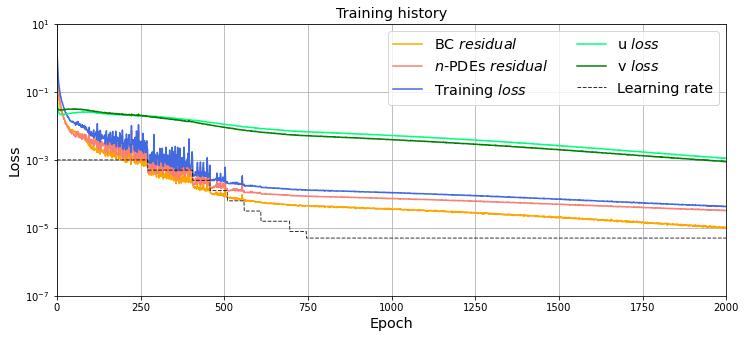

In [24]:
# plot loss history
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
fig, axes = plt.subplots(1, figsize=(12, 5))
plt.plot(hist['epoch'], hist['bc_loss'], label=r'BC $residual$', alpha=1, c='orange');
plt.plot(hist['epoch'], hist['pde_loss'], label=r'$%s$-PDEs $residual$'%(scheme.split('-')[0]), alpha=1, c='salmon');
plt.plot(hist['epoch'], hist['loss'], label=r'Training $loss$', alpha=1, c='royalblue'); plt.yscale('log'); plt.grid();
plt.plot(hist['epoch'], hist['u_loss'], label=r'u $loss$', alpha=1, c='springgreen');
plt.plot(hist['epoch'], hist['v_loss'], label=r'v $loss$', alpha=1, c='green');
plt.plot(hist['epoch'], hist['lr'], "k--", label=r'Learning rate', alpha=.8, linewidth=1);
plt.xlabel('Epoch', size='x-large'); plt.ylabel('Loss', size='x-large'); plt.xlim((0, EPOCH)); plt.ylim((1e-7, 1e1));
plt.title(r'Training history', fontsize="x-large"); plt.legend(fontsize='x-large', ncol=2);

mse u  = 1.169e-03
mse v  = 9.411e-04
mse p  = 1.019e-02


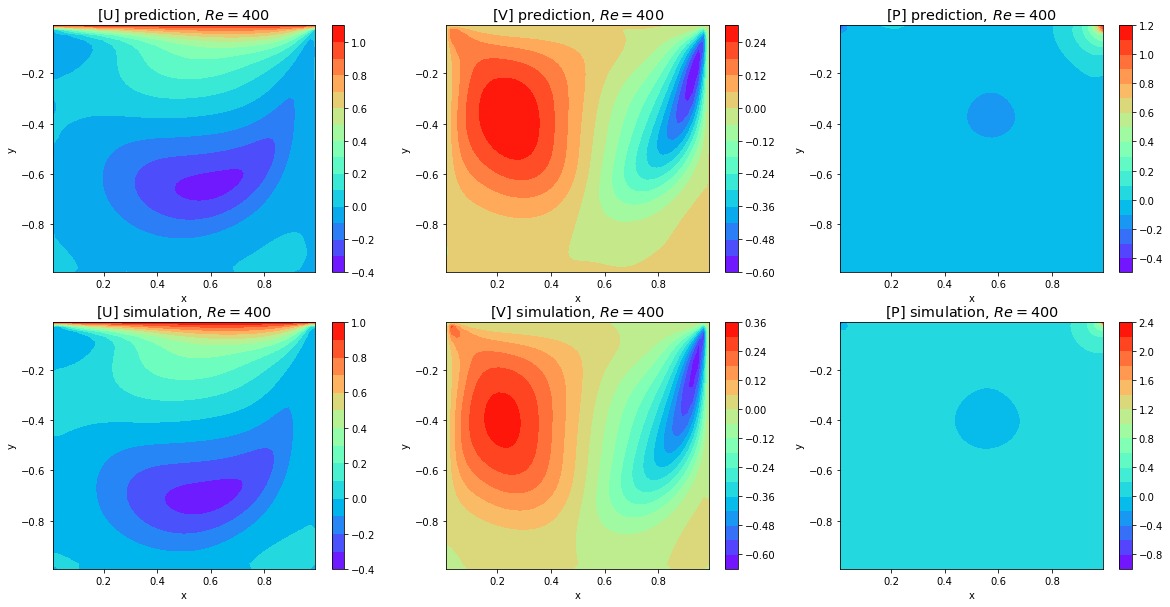

In [17]:
# new prediction & error on [train] data
p_u, p_v, p_p, _, _ = eval_ins(X_train)

# mse
mse_u =  np.mean((p_u.flatten() - y_train[:, 0].flatten())**2)
mse_v =  np.mean((p_v.flatten() - y_train[:, 1].flatten())**2)
mse_p =  np.mean((p_p.flatten() - y_train[:, 2].flatten())**2)
print ('mse u  = %.3e' %mse_u)
print ('mse v  = %.3e' %mse_v)
print ('mse p  = %.3e' %mse_p)

# visualize flow prediction
fig = plt.figure(figsize=(20, 10))

con_lv = 15
n = 51
_pu, _pv, _pp = p_u.reshape(n, n), p_v.reshape(n, n), p_p.reshape(n, n)
_u, _v, _p = y_train[:, 0].reshape(n, n), y_train[:, 1].reshape(n, n), y_train[:, 2].reshape(n, n)

# prediction
ax1 = fig.add_subplot(2,3,1)
plt.contourf(_pu, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title(r'[U] prediction, $Re=$%d' %Re, size='x-large');
ax1 = fig.add_subplot(2,3,2)
plt.contourf(_pv, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title(r'[V] prediction, $Re=$%d' %Re, size='x-large');
ax1 = fig.add_subplot(2,3,3)
plt.contourf(_pp, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title(r'[P] prediction, $Re=$%d' %Re, size='x-large');

# simulation
ax1 = fig.add_subplot(2,3,4)
plt.contourf(_u, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title(r'[U] simulation, $Re=$%d' %Re, size='x-large');
ax1 = fig.add_subplot(2,3,5)
plt.contourf(_v, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title(r'[V] simulation, $Re=$%d' %Re, size='x-large');
ax1 = fig.add_subplot(2,3,6)
plt.contourf(_p, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title(r'[P] simulation, $Re=$%d' %Re, size='x-large');   